In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from pathlib import Path
import audio_features
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import fcluster
import random
import IPython.display as ipd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import json

In [3]:
def json_load(labeled_data_file, parent=None):
    """
    Load a JSON file containing label data in the form:
        filename: Music | Dialogue | Both | None
    Prepend parent as a path if provided to the keys in the dictionary

    Parameters:
    labeled_data_file (str or Path): file containing json data
    parent(str or Path): parent path to prepend to the file names
    """
    with open(labeled_data_file, 'r') as f:
        labeled_data = json.load(f)

    if parent:
        return {str(Path(parent) / k): v for k, v in labeled_data.items()}
    else:
        return {str(Path(k)): v for k, v in labeled_data.items()}

In [4]:
def improve_clustering_with_labeled_data(cluster_data, labeled_data_file, label_parent=None):
    """
    Improve clustering accuracy using a labeled dataset.
    
    Parameters:
    cluster_data (pd.DataFrame): DataFrame containing filenames and cluster labels.
    labeled_data_file (str or Path): Path to the labeled dataset JSON file.
    
    Returns:
    pd.DataFrame: Updated cluster data with improved labels.
    """
    # # Load labeled data from JSON file
    labeled_data = json_load(labeled_data_file, label_parent)
    
    # Extract features for labeled data
    labeled_features = []
    labeled_labels = []
    for filename, label in labeled_data.items():
        if filename in cluster_data['Filename'].values:
            index = cluster_data[cluster_data['Filename'] == filename].index[0]
            labeled_features.append(features[index])
            labeled_labels.append(label)
    
    labeled_features = np.array(labeled_features)
    
    # Debugging: Print the number of labeled features found
    print(f"Number of labeled features found: {len(labeled_features)}")
    
    # Check if labeled_features is empty
    if len(labeled_features) == 0:
        raise ValueError("No matching labeled features found. Ensure that the filenames in the labeled data match those in the cluster data.")
    
    # Split labeled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(labeled_features, labeled_labels, test_size=0.2, random_state=42)
    
    # Train a RandomForest classifier on the labeled data
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    classifier.fit(X_train, y_train)
    
    # Evaluate classifier performance on the test set
    y_pred = classifier.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    
    # Use the trained classifier to predict labels for the cluster data
    cluster_features = np.array([features[idx] for idx in cluster_data.index])
    predicted_labels = classifier.predict(cluster_features)
    prediction_probs = classifier.predict_proba(cluster_features)

    
    # Add predicted labels to the cluster data
    cluster_data['Improved_Label'] = predicted_labels
    cluster_data['Prediction_Probabilities'] = list(prediction_probs)
        
    return cluster_data, classifier

In [15]:
def manual_classify_uncertain_tracks(cluster_data, classifier, threshold=0.6):
    """
    Manually classify uncertain tracks based on prediction probabilities.
    
    Parameters:
    cluster_data (pd.DataFrame): DataFrame containing filenames, predicted labels, and prediction probabilities.
    classifier (RandomForestClassifier): Trained classifier.
    threshold (float): Probability threshold below which tracks are considered uncertain.
    
    Returns:
    pd.DataFrame: Updated cluster data with manual classifications for uncertain tracks.
    """
    # Identify uncertain tracks
    uncertain_indices = []
    for idx, probs in enumerate(cluster_data['Prediction_Probabilities']):
        max_prob = max(probs)
        if max_prob < threshold:
            uncertain_indices.append(idx)
    
    # Manually classify uncertain tracks
    print(f"Manually reclassifying {len(uncertain_indices)} tracks with uncertainty below {threshold}")

    counter = 1
    
    for idx in uncertain_indices:
        print(f"Track {counter} of {len(uncertain_indices)}")
        counter += 1
        track = cluster_data.iloc[idx]['Filename']
        print(f"Playing uncertain track: {track}")
        
        # Automatically play the audio file
        audio = ipd.Audio(track, autoplay=True)
        display_handle = ipd.display(audio, display_id=True)
        
        # Get user classification (M, D, B, or Q to quit)
        user_input = None
        classification_dict = {
            'M': 'Music',
            'B': 'Both',
            'D': 'Dialogue',
            'Q': 'Quit'
        }
        while user_input not in classification_dict.keys():
            user_input = input("Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit): ").upper()
            if user_input == 'Q':
                print("Quitting...")
                return cluster_data
        
        # Update the cluster data with the manual classification
        cluster_data.at[idx, 'Improved_Label'] = classification_dict[user_input]
        
        # Pause between tracks
        time.sleep(1)
        display_handle.update(ipd.HTML(''))
    
    return cluster_data

In [30]:
feature_file = Path('241103_1441_features.csv')
training_data = Path('./TRAINING_DATA/PREPARED/outro/')
labeled_json = Path('./track_classifications_241103.json')

features, filenames = audio_features.read_features_from_file(feature_file)

## Ward Linkage Dendrogram

Use the "ward" method for determining the cutoff of the feature set. The three clusters appear to diverge around 20,000; a value of 20,100 will be used to split the clusters.

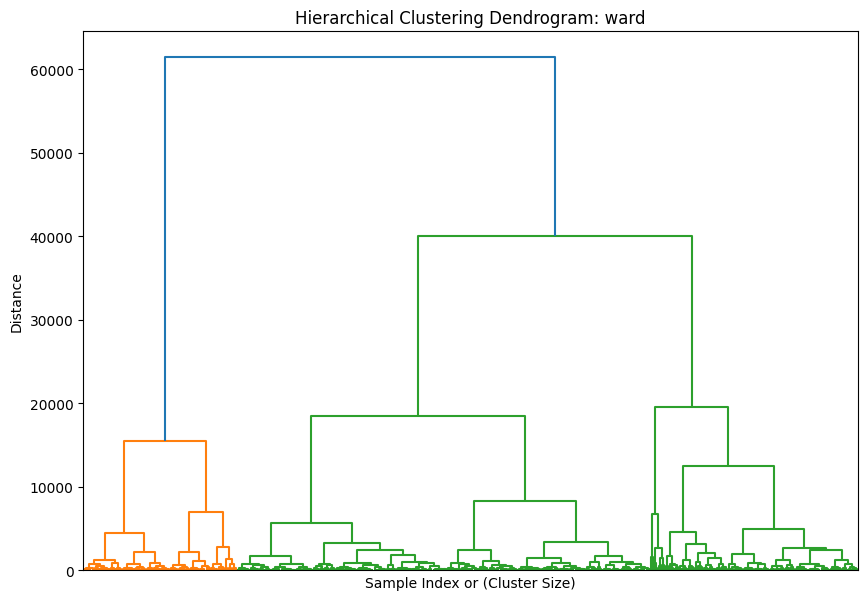

In [32]:
# Perform hierarchical clustering using 'ward' method
linkage_matrix = sch.linkage(features, method='ward')

# Plot dendrogram to visualize clustering
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram: ward')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

## Extract Clusters

Extract the clusters from the whole and generate two groupings: orange and green. Write these out to a playlist that can be manually examined.

In [8]:
# Extract cluster assignments by cutting the dendrogram
# Cut the dendrogram at a specific distance to get 2 clusters
distance_threshold = 20100 # Adjust this value as needed to separate clusters
cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')

# Create a DataFrame to analyze clusters
cluster_data = pd.DataFrame({'Filename': filenames, 'Cluster': cluster_labels})

# Investigate the clusters
cluster_1 = cluster_data[cluster_data['Cluster'] == 1]
cluster_2 = cluster_data[cluster_data['Cluster'] == 2]

# Display information about the clusters
print("Orange:")
print(cluster_1)
print("\nGreen 2:")
print(cluster_2)

# Example usage: write M3U files for clusters
audio_features.write_m3u(cluster_1, 'ward_orange_001.m3u')
audio_features.write_m3u(cluster_2, 'ward_green_001.m3u')

Orange:
                                               Filename  Cluster
3     TRAINING_DATA/PREPARED/outro/009-20241021_me_a...        1
6     TRAINING_DATA/PREPARED/outro/019-20241003_atc_...        1
8     TRAINING_DATA/PREPARED/outro/013-20241022_atc_...        1
11    TRAINING_DATA/PREPARED/outro/009-20240928_wesa...        1
20    TRAINING_DATA/PREPARED/outro/016-20241028_atc_...        1
...                                                 ...      ...
1348  TRAINING_DATA/PREPARED/outro/009-20241002_me_4...        1
1349  TRAINING_DATA/PREPARED/outro/014-20241024_atc_...        1
1356  TRAINING_DATA/PREPARED/outro/015-20241007_me_a...        1
1361  TRAINING_DATA/PREPARED/outro/005-20241010_atc_...        1
1362  TRAINING_DATA/PREPARED/outro/015-20241025_me_p...        1

[272 rows x 2 columns]

Green 2:
                                               Filename  Cluster
0     TRAINING_DATA/PREPARED/outro/008-20241001_me_j...        2
1     TRAINING_DATA/PREPARED/outro/004-20240929_

## Refine Clusters

Use the `improve_clustering_with_labeled_data` function to apply manually labeled items as a ground truth. This should theoretically improve the accuracy.

In [17]:
refined_cluster_data, classifier = improve_clustering_with_labeled_data(cluster_data, 
                                                            labeled_json, training_data)

Number of labeled features found: 413

Classification Report:
              precision    recall  f1-score   support

        Both       0.76      0.78      0.77        36
    Dialogue       0.86      0.92      0.89        39
       Music       0.50      0.25      0.33         8

    accuracy                           0.80        83
   macro avg       0.70      0.65      0.66        83
weighted avg       0.78      0.80      0.78        83

Accuracy: 0.80


## Manually Classify the Most Uncertain

Manually listten to and classify the most uncertain tracks. A threshold of 60% uncertainty was chosen.

In [18]:
# Refine the clusters using manual classification of uncertain tracks
refined_cluster_data = manual_classify_uncertain_tracks(cluster_data, classifier, threshold=0.6)

Manually reclassifying 183 tracks with uncertainty below 0.6
Track 1 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241024_atc_free_blockbuster_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 2 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20240927_me_2_teens_in_nevada_acknowledge_that_risk_goes_along_with_being_rodeo_cowboys_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 3 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241006_wesun_trump_harris_speak_from_the_campaign_trail_on_hurricane_helene_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 4 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20240927_me_book_recommendations_for_hispanic_heritage_month_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 5 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241010_me_wnba_finals_cap_a_season_of_unprecedented_growth_and_attention_for_the_league_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 6 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241030_atc_az_gallego_and_native_outreach_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 7 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241017_atc_jeffries_campaigns_to_flip_house_and_become_first_black_speaker_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 8 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241001_atc_iran_fires_missiles_at_israel_as_israel_invades_lebanon_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 9 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241102_wesat_election_betting_in_2024_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 10 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241012_wesat_trump_has_made_a_colorado_town_central_to_his_narrative._residents_want_no_part_of_it_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 11 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/011-20240926_me_trump_and_harris_plan_to_end_taxes_on_tips._the_reaction_is_mixed_in_las_vegas_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 12 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20241026_atc_uk-surfers_against_sewage_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 13 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241001_atc_water_supplies_are_dwindling_in_asheville_after_helene_s_devastation_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 14 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241026_wesat_dodgers_fans_pay_tribute_to_beloved_former_pitcher_fernando_valenzuela_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 15 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241011_atc_indoor_workers_in_california_are_learning_about_their_right_to_heat_protections_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 16 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241003_me_gates_of_gaza_tells_the_story_of_a_kibbutz_before_and_after_hamas_attack_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 17 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/001-20241023_me_morning_news_brief_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 18 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241018_atc_happy_place_--_reba_mcentire_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 19 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241021_atc_no_copay_contraceptives_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 20 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/011-20241028_atc_internment_camp_baseball_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 21 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241024_me_donald_trump_is_doubling_down_on_threats_against_those_he_sees_as_his_enemies_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 22 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241015_me_jennifer_koh_seeks_innovation_and_artistic_risk_in_revamping_chamber_music_series_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 23 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/011-20241024_me_philadelphia-based_singer-songwriter_khalil_amaru_performs_live_on_morning_edition_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 24 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241031_atc_how_the_parrot_got_its_colors_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 25 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20240927_me_sophie_s_posthumous_album_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 26 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241029_me_halloween_is_just_days_away_--_time_for_candy_and_other_treats_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 27 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/011-20241028_me_trump_and_harris_campaigns_concentrate_on_swing_voters_in_the_homestretch_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 28 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20240928_wesat_how_china_keeps_a_hold_on_the_supply_chain_of_critical_minerals_used_for_evs_and_ai_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 29 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241002_atc_a_beloved_music_producer_is_dying._his_clients_came_to_his_home_for_a_farewell_concert_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 30 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241003_me_gladwell_reexamines_the_tipping_point_releasing_revenge_of_the_tipping_point_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 31 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20241004_me_batman_s_nemesis_joker_returns_to_theaters_--_this_time_he_s_got_a_song_in_his_heart_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 32 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241007_atc_pharrell_says_his_hit_happy_came_from_a_sarcastic_place_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 33 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241008_atc_are_crocs_bad_for_kids_feet_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 34 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20240930_atc_fight_night_brings_election_drama_to_theaters_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 35 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241019_wesat_opinion_yer_out_eric_adams_fashion_faux_pas_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 36 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20241017_me_npr_s_planet_money_team_asks_can_cap_and_trade_work_in_the_u.s._chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 37 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241011_atc_disclaimer_is_a_sprawling_thriller_built_for_the_streaming_age_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 38 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241025_atc_doj_lawyers_call_on_attorney_general_to_investigate_potential_israeli_killings_of_us_citizens_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 39 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241027_atc_we_seth_meyers_watc_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 40 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241024_atc_blinken_believes_the_death_of_hamas_leader_may_allow_for_a_ceasefire_and_hostage_deal_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 41 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241017_me_why_climate_change_is_hurting_older_americans_finances_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 42 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/015-20241005_wesat_the_democratic_republic_of_congo_has_received_mpox_vaccinations._are_they_enough_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 43 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241012_wesat_suki_waterhouse_on_her_new_album_memoir_of_a_sparklemuffin_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 44 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241026_atc_grate_cheese_heist_a_massive_loss_for_london_s_neal_s_yard_dairy_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 45 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241006_wesun_how_to_preserve_your_personal_mementos_in_a_natural_disaster_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 46 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241024_atc_docs_in_mn_see_influx_of_trans_patients_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 47 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241031_me_author_yvette_montoya_reimagines_loter_a_aka_latino_bingo_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 48 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241005_wesat_colleges_are_having_special_trainings_for_incoming_students_after_the_year_of_protests_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 49 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241003_atc_climate_scientist_goes_through_hurricane_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 50 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20240926_atc_former_nfl_qb_tom_brady_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 51 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241028_me_pumpkin_carver_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 52 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241015_atc_mental_health_hurricanes_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 53 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241015_atc_silent_hill_2_and_konami_s_future_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 54 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241101_atc_the_next_u.s._president_could_make_a_big_difference_for_ukrainians_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 55 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241102_wesat_wisconsin_democrats_are_hoping_new_voting_maps_will_help_them_win_the_state_race_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 56 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20241021_atc_turner-head_start_changes_1_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 57 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241011_me_trump_to_hold_rally_in_colorado_city_that_he_says_was_overrun_by_migrant_gangs_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 58 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20241020_wesun_mexican_president_claudia_sheinbaum_outlines_her_plan_to_tackle_cartel_violence_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 59 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241027_atc_dua_lipa_talks_about_her_new_album_and_playing_a_venue_like_the_tiny_desk_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 60 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241027_wesun_here_s_one_of_the_only_places_you_can_ride_in_a_filipino_jeepney_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 61 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241101_me_the_cure_s_songs_of_a_lost_world_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 62 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241024_me_why_female_pop_artists_have_been_screaming_in_their_songs_a_lot_lately_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 63 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241021_me_cuba_goes_into_a_4th_day_without_electricity_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 64 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/015-20241003_atc_utah_public_lands_takeover_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 65 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241026_wesat_1931_film_dr_cula_gets_its_first_film_score_just_in_time_for_halloween_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 66 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20241020_wesun_little_is_known_about_the_striped_skunk_s_smellier_spotted_cousin._that_s_changing_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 67 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241001_me_vance_background_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 68 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20240928_atc_unseen_footage_of_john_f._kennedy_s_assassination_is_up_for_auction_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 69 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241101_me_john_leguizamo_s_parents_knew_the_american_dream_hustle._that_informed_his_new_play_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 70 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20240929_wesun_an_atlanta_tribute_concert_celebrated_former_president_jimmy_carter_s_100th_birthday_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 71 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20240926_me_morning_news_brief_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 72 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241023_me_former_abercrombie_ceo_arrested_on_sex_trafficking_charges_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 73 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241002_me_millicent_quibb_school_of_etiquette_for_young_ladies_of_mad_science_by_kate_mckinnon_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 74 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/001-20240926_me_fighting_between_israel_and_hezbollah_puts_jordan_in_an_uncomfortable_spot_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 75 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241015_me_rhiannon_giddens_swannanoa_tunnel_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 76 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241010_atc_novel_foster_care_program_in_ohio_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 77 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/020-20241026_wesat_sophie_allison_of_soccer_mommy_on_her_new_album_evergreen_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 78 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241025_atc_harris_makes_bid_for_republican_votes_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 79 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241030_atc_review-a_real_pain_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 80 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241003_atc_election_changes_ballot_measures_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 81 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20240927_me_israeli_airstrikes_leave_blast_sites_and_wounded_in_lebanon_s_bekaa_valley_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 82 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/015-20241013_wesun_river_runners_are_celebrating_whitewater_rapids_re-emerging_in_colorado_s_lake_powell_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 83 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20240927_me_2_teens_in_nevada_acknowledge_that_risk_goes_along_with_being_rodeo_cowboys_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 84 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241015_atc_green_day_dookie_demastered_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 85 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241028_atc_voting_day_arizona_tribal_school_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 86 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20240926_atc_hearings_begin_on_first_trump_assassination_attempt_suggest_security_failures_on_many_fronts_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 87 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241101_atc_the_next_u.s._president_could_make_a_big_difference_for_ukrainians_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 88 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241030_me_louisiana_schools_use_artificial_intelligence_to_help_young_children_learn_to_read_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 89 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241015_atc_encore_new_florida_storm_defenses_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 90 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241031_me_volunteers_including_friends_of_kamala_harris_are_knocking_on_doors_in_wisconsin_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 91 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/011-20241019_wesat_massive_blackout_in_cuba_leaves_10_million_people_on_the_island_without_power_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 92 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241029_me_to_enshrine_abortion_rights_into_florida_constitution_the_change_needs_60_approval_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 93 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241015_atc_utah_geothermal_to_los_angeles_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 94 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241014_atc_wildlife_services_feature_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 95 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241028_me_while_in_pennsylvania_for_election_stories_morning_edition_stopped_by_gettysburg_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 96 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241014_atc_the_indian_card_who_gets_to_be_native_in_america_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 97 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241023_atc_book_partiot-navalny-part_ii_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 98 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20241013_atc_actor_gael_garc_a_bernal_plays_a_game_of_wild_card_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 99 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241026_wesat_biden_apologizes_for_government_s_role_in_running_native_american_boarding_schools_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 100 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/015-20241023_me_remembering_dodgers_pitching_star_fernando_valenzuela_who_died_at_age_63_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 101 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241017_atc_lake_michigan_craters_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 102 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241024_me_rock_musician_chuck_prophet_finds_a_silver_lining_in_his_cancer_diagnosis_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 103 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241015_me_songs_that_move_you_ojal_que_llueva_caf_by_juan_luis_guerra_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 104 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20240930_me_why_some_historically_black_colleges_and_universities_are_seeing_an_enrollment_boost_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 105 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241003_atc_visiting_the_world_s_biggest_elvis_festival_in_unexpectedly_a_small_town_in_wales_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 106 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241006_atc_fight_club_and_the_matrix_through_the_years_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 107 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20240926_me_how_asian_american_voters_in_nevada_are_feeling_about_november_s_election_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 108 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241028_atc_a_small_silver_lining_to_the_colorado_river_drought_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 109 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241031_atc_puerto_rico_election_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 110 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241026_wesat_sophie_allison_of_soccer_mommy_on_her_new_album_evergreen_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 111 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20240927_me_sophie_s_posthumous_album_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 112 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/008-20241011_atc_japan_wrongful_conviction_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 113 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241102_wesat_a_new_rule_could_make_it_easier_to_fix_the_mcdonald_s_ice_cream_machine_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 114 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241002_atc_shrimp_tail-gate_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 115 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241011_me_cvs_and_walgreens_close_stores_--_rethink_their_role_in_our_lives_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 116 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241003_me_rural_n.c._residents_examine_the_damage_from_helene_and_wonder_what_to_do_next._chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 117 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241027_wesun_trump_and_harris_ramp_up_the_rhetoric_on_the_campaign_trail_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 118 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241026_atc_pod_corner_last_seen_chunk_41.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 119 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241026_wesat_dodgers_fans_pay_tribute_to_beloved_former_pitcher_fernando_valenzuela_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 120 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241016_atc_wc_gael_garcia_bernal_atc_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 121 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20240926_atc_cannabis_and_public_health_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 122 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241019_wesat_school_counselors_are_using_creative_ways_to_help_kids_cope_with_the_trauma_of_floods_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 123 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241017_atc_lebanon-a_portrait_of_dahieh_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 124 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20240930_atc_rock_glaciers_rock_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 125 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241007_atc_rookie_quarterbacks_are_making_a_splash_in_the_nfl_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 126 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241002_atc_terry_crews_describes_growing_up_and_experiencing_awe_on_wild_card_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 127 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/015-20241004_atc_baseball_audio_delay_impacts_blind_fans_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 128 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241017_atc_pmi_cutdown_reading_glasses_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 129 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241020_wesun_researchers_are_skeptical_of_this_gunfire_detection_system._chicago_no_longer_uses_it_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 130 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241029_atc_ballot_box_arson_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 131 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241030_atc_manuel_el_guajiro_mirabal-one_of_the_last_buena_vista_social_club_s_members-has_died_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 132 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20241030_atc_lebanon_s_only_burn_unit_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 133 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241030_atc_after_nearly_four_months_shaboozey_s_run_atop_the_pop_chart_is_interrupted_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 134 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241003_atc_encore_kate_mckinnon_s_first_book_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 135 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20240929_atc_what_do_rising_middle_east_tensions_mean_for_the_us_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 136 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241026_atc_north_carolina_votes_the_view_from_a_raleigh_church_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 137 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241021_atc_sports_politics_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 138 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241022_atc_unsung_hero-malcolm_campbell_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 139 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/001-20241031_atc_southwest_campaign_swing_az_nv_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 140 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241024_atc_dua_lipa_tiny_desk_chat_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 141 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241014_atc_marathoner_record_breaker_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 142 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241007_me_trump_and_his_faithful_followers_return_to_butler_pa._to_energize_the_flock_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 143 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241020_atc_some_in_the_haitian_community_find_a_home_in_tijuana_mexico_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 144 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241008_me_mexico_mayor_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 145 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241001_atc_last_coal_plant_in_uk_closes_marking_milestone_in_fight_against_climate_change_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 146 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241031_atc_review_the_diplomat_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 147 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241009_atc_how_women_made_music_book_looks_at_the_role_of_women_in_popular_music_for_decades_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 148 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241002_atc_iran_s_missile_strike_explained_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 149 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20240927_me_how_do_you_finish_a_visionary_artist_s_final_album_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 150 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241011_atc_palestinian_citizens_of_israel_after_oct_7_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 151 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241031_atc_sing_sing_film_fest_chunk_31.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 152 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241021_me_attracting_discouraged_voters_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 153 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241026_atc_well_man_identified_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 154 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/010-20241017_me_one_of_ukraine_s_most_celebrated_poets_is_touring_the_united_states_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 155 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241001_atc_pennsylvania_s_gov._shapiro_is_not_shocked_the_race_is_still_so_close_in_his_state_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 156 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241004_atc_review-joker_saturday_night_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 157 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20241004_atc_in_swing-state_wisconsin_new_districts_threaten_the_gop_hold_on_the_legislature_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 158 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241001_me_vance_background_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 159 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241021_atc_marathon_t_c_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 160 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/014-20241030_atc_rio_s_most_notorious_murder_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 161 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241026_atc_pod_corner_last_seen_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 162 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241023_atc_come_hell_or_high_water_early_voting_is_happening_in_storm-ravaged_north_carolina_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 163 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241017_atc_review-anora_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 164 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/016-20241004_atc_guaranteed_income_for_artists_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 165 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/005-20241031_atc_sing_sing_film_fest_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 166 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/003-20241025_atc_what_s_it_like_when_a_childhood_dream_leads_you_to_the_world_series_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 167 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/009-20241005_wesat_betty_members_reflect_on_their_new_album_and_38_years_of_the_band_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 168 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241031_atc_throughline-swing_states_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 169 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/012-20241021_me_encore_sudan_diaspora_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 170 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241101_atc_small_claims_court_debt_mills_chunk_21.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 171 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241029_me_the_mystery_of_a_photographer_and_his_forbidden_photos_of_nazi-occupied_france_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 172 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/013-20241031_atc_preserving_history_at_graveyards_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 173 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/001-20241031_atc_southwest_campaign_swing_az_nv_chunk_31.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 174 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/019-20241030_atc_after_nearly_four_months_shaboozey_s_run_atop_the_pop_chart_is_interrupted_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 175 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/018-20241022_atc_voters_and_the_educational_divide_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 176 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/001-20240927_me_morning_news_brief_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 177 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20240928_wesat_in_the_film_a_different_man_a_new_york_actor_takes_a_life-changing_risk_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 178 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/002-20240928_wesat_opinion_remembering_the_marvel_maggie_smith_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 179 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/004-20241025_me_conclave_starring_ralph_fiennes_dramatizes_the_search_for_a_new_pope_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Track 180 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/006-20241019_atc_gory_low-budget_slasher_terrifier_3_tops_the_box_office_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 181 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/007-20241024_me_anthony_s_italian_coffee_and_chocolate_house_in_south_philly_hosts_morning_edition_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Track 182 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241029_atc_midwest_msg_voter_views_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Track 183 of 183
Playing uncertain track: TRAINING_DATA/PREPARED/outro/017-20241026_wesat_1931_film_dr_cula_gets_its_first_film_score_just_in_time_for_halloween_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


### Write the refined clusters to m3u 

Write out m3u playlists that can be manually played and classified once again to verify accuracy. These will become the training sets for future training of models.

In [ ]:
# save the new label data to a CSV
# refined_cluster_data.to_csv('refined_labels_241105.csv', index=False)

# Load refined cluster data from CSV
refined_csv_path = 'refined_labels_241105.csv'
refined_cluster_data = pd.read_csv(refined_csv_path)

# Write M3U files for newly refined clusters
for label in refined_cluster_data['Improved_Label'].unique():
    subset = refined_cluster_data[refined_cluster_data['Improved_Label'] == label]
    audio_features.write_m3u(subset, f'00_refined_{label.lower()}_playlist.m3u')

# Extract features and improved labels from the refined cluster data
refined_features = []
refined_labels = []

for idx, row in refined_cluster_data.iterrows():
    filename = row['Filename']
    if filename in filenames:
        index = filenames.index(filename)
        refined_features.append(features[index])
        refined_labels.append(row['Improved_Label'])

# Convert to NumPy array for training
refined_features = np.array(refined_features)

In [28]:
refined_cluster_data['Improved_Label'].value_counts()

Improved_Label
Dialogue    703
Both        510
Music       157
Name: count, dtype: int64

## Verify Refined Clusters

The m3u files containing the three clusters can be sampled and reviewed. The function below plays a random selection from an m3u file and records classifications. The totals can then be reviewed.

In [ ]:
from pathlib import Path
import random
import IPython.display as ipd
import time
import pandas as pd


def play_and_classify_m3u(m3u_file, output_file=None, num_tracks=20):
    """
    Play a specified random number of items from an M3U file, ask user to classify as M, D, B, 
    and record the values in a file, displaying the ratio of M, D, B.
    Press 'Q' to quit at any time.
    
    Parameters:
    m3u_file (str or Path): Path to the M3U file.
    output_file (str or Path): Path to the output file where classifications are saved.
    num_tracks (int, optional): Number of tracks to play. If None, a random number of tracks will be played.
    """
    m3u_file = Path(m3u_file)

    if not output_file:
        output_file = m3u_file.parent / (m3u_file.stem + '_classification.csv')
    else:
        output_file = Path(output_file)
    
    # Read M3U file
    with m3u_file.open('r') as f:
        lines = f.readlines()
    
    # Filter lines to get only filenames (skip #EXTM3U and other comments)
    tracks = [line.strip() for line in lines if not line.startswith('#')]
    
    # Read existing classifications if the output file exists
    classified_tracks = set()
    classifications = {'M': 0, 'D': 0, 'B': 0}
    if output_file.exists():
        classified_df = pd.read_csv(output_file)
        classified_tracks.update(classified_df['Filename'].tolist())
        # Update the classification counts with existing data
        existing_classifications = classified_df['Classification'].value_counts().to_dict()
        for key in ['M', 'D', 'B']:
            if key in existing_classifications:
                classifications[key] += existing_classifications[key]
    else:
        with output_file.open('w') as out_file:
            out_file.write('Filename,Classification\n')
    
    # Filter out tracks that have already been classified
    tracks_to_play = [track for track in tracks if track not in classified_tracks]
    
    # Randomly shuffle the list of tracks to play
    random.shuffle(tracks_to_play)
    
    # Determine the number of tracks to play
    num_tracks = min(num_tracks, len(tracks_to_play))
    
    # Open output file for appending classifications
    with output_file.open('a') as out_file:
        # Play each track and ask for classification
        for i in range(num_tracks):
            track = tracks_to_play[i]
            print(f"Playing track {i + 1} of {num_tracks}: {track}")
            
            # Automatically play the audio file
            audio = ipd.Audio(track, autoplay=True)
            display_handle = ipd.display(audio, display_id=True)
            
            # Get user classification (M, D, B, or Q to quit)
            classification = None
            while classification not in ['M', 'D', 'B', 'Q']:
                classification = input("Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit): ").upper()
                if classification == 'Q':
                    print("Quitting...")
                    return
            
            # Record classification if not quitting
            if classification != 'Q':
                classifications[classification] += 1
                out_file.write(f"{track},{classification}\n")
            
            # Pause between tracks
            time.sleep(1)
            display_handle.update(ipd.HTML(''))
    
    # Calculate and display ratio of classifications
    total_classifications = sum(classifications.values())
    print("\nClassification Ratios:")
    for key, value in classifications.items():
        ratio = value / total_classifications if total_classifications > 0 else 0
        print(f"{key}: {ratio:.2f}")
    dialog_pct = classifications["D"] / total_classifications
    music_both_pct = (classifications["M"] + classifications["B"]) / total_classifications
    print(f"Music & Both: {music_both_pct * 100}; Dialogue: {dialog_pct * 100}")
    return classifications

result = {}
for i in ['./00_refined_both_playlist.m3u', './00_refined_dialogue_playlist.m3u', './00_refined_music_playlist.m3u']:
    result[i] = play_and_classify_m3u(i)